In [1]:
import numpy as np
import pandas as pd

import sklearn as sk
import matplotlib.pyplot as plt
from obspy import Stream, Trace, UTCDateTime
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

import pylab as pl
from keras.callbacks import ModelCheckpoint

import keras

from keras.layers import Activation, Conv1D, Dense, Dropout, Flatten, MaxPooling3D, BatchNormalization, InputLayer, LSTM
from keras.layers import Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.losses import categorical_crossentropy
from keras.models import Sequential
from keras.utils import Sequence
from keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import ParameterGrid
import re
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

from DataGenerator import DataGenerator
from Models import Models
from LoadData import LoadData
from BaselineHelperFunctions import BaselineHelperFunctions
from RandomGridSearch import RandomGridSearch
from CustomCallback import CustomCallback
from MinMaxScalerFitter import MinMaxScalerFitter
from livelossplot import PlotLossesKeras

from Tf_shutup import Tf_shutup
Tf_shutup()
import tensorflow as tf

from matplotlib.colors import ListedColormap
%matplotlib inline
plt.rcParams["figure.figsize"]= (15,15)
helper = BaselineHelperFunctions()

import sys
ISCOLAB = 'google.colab' in sys.modules

import random
import pprint

# TODO: Implement StandardScaler in generator

In [2]:
csv_root = 'csv_folder_3_class'
loadData = LoadData(csv_root, isBalanced = True)
shuffle = False
full_ds, train_ds, val_ds, test_ds = loadData.getDatasets(shuffle = shuffle)
data_gen = DataGenerator(csv_root)

In [3]:
"""
{'batch_size': 256, 'epochs': 80, 'learning_rate': 0.0001, 'optimizer': 'sgd'}
{'activation': 'relu', 'dropout_rate': 0.5, 'filters': 13, 'kernel_size': 3, 'l1_r': 0.3, 'l2_r': 0.1, 
'output_layer_activation': 'softmax', 'padding': 'same', 'start_neurons': 4}

"""
############ Model picker #############
model_nr = 5

########### Hyperparameters ###########
batch_size = 64
epochs = 80
learning_rate = 0.0001
#opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, clipnorm=1.0, clipvalue=0.5)
opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
activation = 'relu'
dropout_rate = 0.2
filters = 43
kernel_size = 15
l1_r = 0.1
l2_r = 0.1
padding = 'valid'
start_neurons = 516

########### Preprocessing ###########
test = True
num_classes = 3
detrend = False
useScaler = True
use_highpass = True
highpass_freq = 0.2

In [4]:
num_ds, channels, timesteps = data_gen.get_trace_shape_no_cast(train_ds)
input_shape = (batch_size, channels, timesteps)

build_model_args = {'model_nr' : model_nr,
                    'input_shape' : input_shape,
                    'num_classes' : num_classes,
                    'dropout_rate' : dropout_rate,
                    'activation' : activation,
                    'l2_r' : l2_r,
                    'l1_r' : l1_r,
                    'full_regularizer' : True,
                    'start_neurons' : start_neurons,
                    'filters' : filters,
                    'kernel_size' : kernel_size,
                    'padding' : 'same'}
model = Models(**build_model_args).model

model_args = {'loss' : "categorical_crossentropy",
              'optimizer' : opt,
              'metrics' : ["accuracy","MSE",
                           tf.keras.metrics.Precision(thresholds=None, top_k=None, class_id=None, name=None, dtype=None),
                           tf.keras.metrics.Recall(thresholds=None, top_k=None, class_id=None, name=None, dtype=None)]}
model.compile(**model_args)

softmax
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (64, 3, 43)               3870688   
_________________________________________________________________
batch_normalization (BatchNo (64, 3, 43)               172       
_________________________________________________________________
flatten (Flatten)            (64, 129)                 0         
_________________________________________________________________
dense (Dense)                (64, 3)                   390       
Total params: 3,871,250
Trainable params: 3,871,164
Non-trainable params: 86
_________________________________________________________________


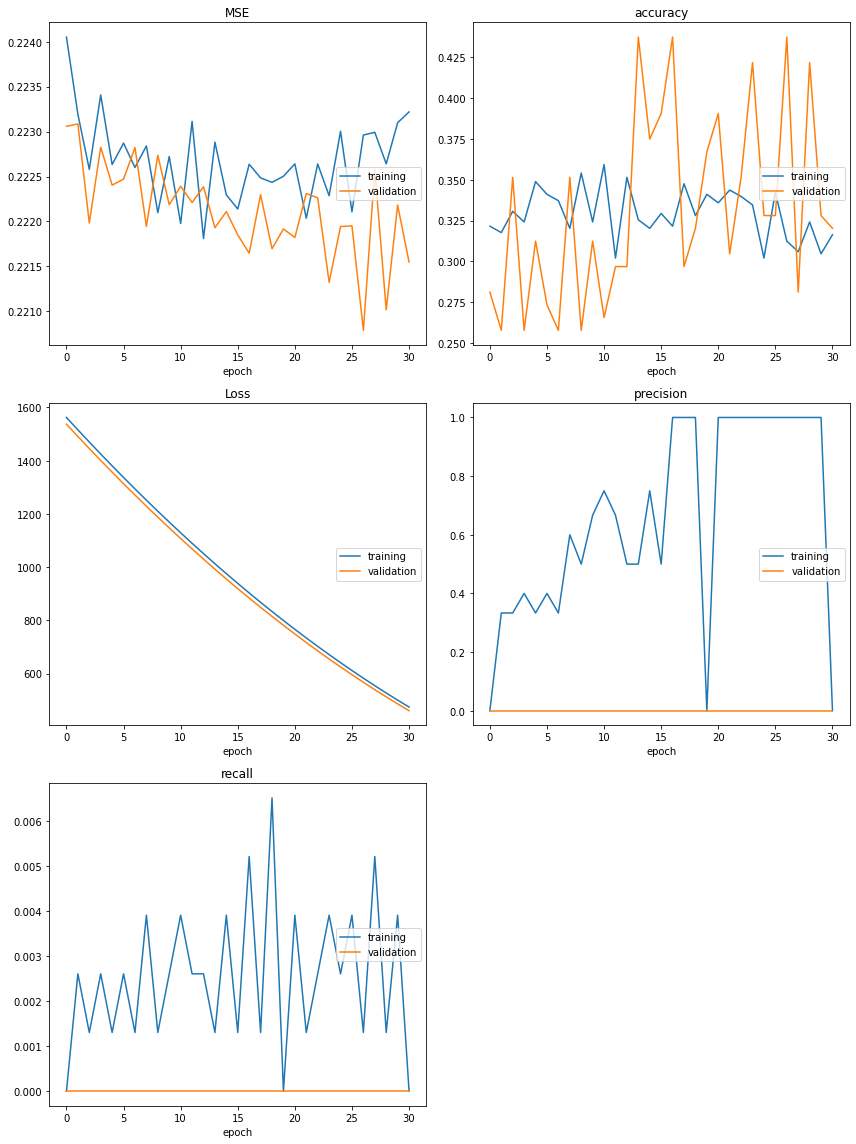

MSE
	training         	 (min:    0.222, max:    0.224, cur:    0.223)
	validation       	 (min:    0.221, max:    0.223, cur:    0.222)
accuracy
	training         	 (min:    0.302, max:    0.359, cur:    0.316)
	validation       	 (min:    0.258, max:    0.438, cur:    0.320)
Loss
	training         	 (min:  474.584, max: 1562.450, cur:  474.584)
	validation       	 (min:  460.733, max: 1537.140, cur:  460.733)
precision
	training         	 (min:    0.000, max:    1.000, cur:    0.000)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)
recall
	training         	 (min:    0.000, max:    0.007, cur:    0.000)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)
12/12 [==============================] - 23s 2s/step - loss: 474.5843 - accuracy: 0.3164 - MSE: 0.2232 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 460.7333 - val_accuracy: 0.3203 - val_MSE: 0.2215 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 32/80
12/12 [=======================

In [ ]:
scaler = MinMaxScalerFitter(train_ds).fit_scaler(test = test, detrend = detrend)

gen_args = {
    'batch_size' : batch_size,
    'test' : test,
    'detrend' : detrend,
    'useScaler' : useScaler,
    'scaler' : scaler,
    'num_classes' : num_classes,
    'use_highpass' : use_highpass,
    'highpass_freq' : highpass_freq
}


train_gen = data_gen.data_generator(train_ds, **gen_args)
val_gen = data_gen.data_generator(val_ds, **gen_args)
test_gen = data_gen.data_generator(test_ds, **gen_args)

custom_callback = CustomCallback(data_gen)

args = {'steps_per_epoch' : helper.get_steps_per_epoch(train_ds, batch_size, test),
        'epochs' : epochs,
        'validation_data' : val_gen,
        'validation_steps' : helper.get_steps_per_epoch(val_ds, batch_size, test),
        'verbose' : 1,
        'use_multiprocessing' : False, 
        'workers' : 1,
        'callbacks' : [PlotLossesKeras()]
}

model_fit = model.fit(train_gen, **args)

In [ ]:
print(scaler.data_max_)

In [ ]:
full_logs = custom_callback.full_training_logs

In [ ]:
helper.get_n_points_with_highest_training_loss(train_ds, 100, full_logs)

In [ ]:
def get_n_points_with_highest_training_loss(full_logs, train_ds, n):
    train_ds_dict = {}
    for path, label in train_ds:
        train_ds_dict[path] = {'label' : label,
                               'loss': 0,
                               'average_loss' : 0,
                               'occurances' : 0}
    counter = 0
    for batch in full_logs:
        loss = batch['loss']
        for path_class in batch['batch_samples']:
            train_ds_dict[path_class[0]]['loss'] += loss
            train_ds_dict[path_class[0]]['occurances'] += 1
    
    train_ds_list = []
    for sample in np.array(train_ds[:,0]):
        if train_ds_dict[sample]['occurances'] == 0:
            continue
        train_ds_dict[sample]['average_loss'] = train_ds_dict[sample]['loss'] / train_ds_dict[sample]['occurances']
        train_ds_list.append((sample, train_ds_dict[sample]['label'],train_ds_dict[sample]['average_loss']))
    
    sorted_train_ds_list = sorted(train_ds_list, key=lambda x: x[2], reverse = True)
        
    
    return sorted_train_ds_list[0:n]
        
get_n_points_with_highest_loss(full_logs, train_ds, 100)   
    

In [ ]:
model.evaluate_generator(generator=test_gen, steps=helper.get_steps_per_epoch(test_ds, batch_size, test))

In [ ]:
steps = len(test_ds) / batch_size
predictions = model.predict_generator(test_gen, steps)
for prediction in predictions:
    prediction_max_index  = np.where(prediction == max(prediction))
    for i in range(len(prediction)):
        if i == prediction_max_index[0]:
            prediction[i] = 1
        else:
            prediction[i] = 0

In [ ]:
import h5py
import json

def load_dataset(data_csv):
        columns = ["path", "label"]
        df = pd.read_csv(data_csv, names = columns)
        df = df.sample(frac = 1)
        return df.values



y_true = load_dataset(test_csv)[:,1]
print(y_true[0])

In [ ]:
label_dict = {'explosion':0, 'earthquake':1, 'noise':2, 'induced':3}
y_true_int = np.empty((len(y_true)), dtype=int)
for i in range(len(y_true)):
    y_true_int[i] = label_dict.get(y_true[i])

print(y_true_int)

y_true_categorical = np_utils.to_categorical(y_true_int, 3, dtype=np.int64)

In [ ]:
y_true

In [ ]:
print(confusion_matrix(y_true_categorical.argmax(axis=1), predictions[0:1234].argmax(axis=1)))

In [ ]:
helper.plot_confusion_matrix(model, test_gen, test_ds, batch_size)

In [ ]:
model.predict_generator(val_gen, 2)

In [ ]:
helper.plot_confusion_matrix(test_ds, batch_size)

In [ ]:
steps = len(test_ds)/batch_size
predictions = model.predict_generator(test_gen, steps)
predicted_classes = helper.convert_to_class(predictions)[0:(len(test_ds))]
true_classes = helper.get_class_array(test_ds, 3)
print(len(predicted_classes), len(true_classes))

In [ ]:
X, y = next(train_gen)
print(X[0], y[0])


In [ ]:
x = scaler.transform(X[0])

In [ ]:
x

In [ ]:
def load_dataset(data_csv):
    columns = ["path", "label"]
    df = pd.read_csv(data_csv, names = columns)
    df = df.sample(frac = 1)
    return df.values

In [ ]:
load_dataset(train_csv)